<a href="https://colab.research.google.com/github/darkwings/ai-notebooks/blob/main/The_Researcher_version_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Researcher (version 1)

This notebook implements a simple search workflow targeted to the composition of an *essay* about a specific topic, with critique functionalities to drive the review of the essay.

This is the first version, based on web search performed by Tavily.

## What's next

Next versions of the researcher will include

- parallel search and aggregation of results
- access to local documents with Vector Store (Self RAG)


## Let's do it

The implementation is based on [LangGraph](https://www.langchain.com/langgraph)

Let's start with the setup

In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langchain_community langgraph tavily-python

In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


In [3]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


Now, let's import all the needed stuff and declare

- the main [state](https://medium.com/@gitmaxd/understanding-state-in-langgraph-a-comprehensive-guide-191462220997) of the Graph
- some objects that we're going to use as [structured output](https://python.langchain.com/docs/concepts/structured_outputs/)

In [10]:
from typing import TypedDict, List, Optional, Any
import asyncio
from langchain_openai import ChatOpenAI
import operator
from pydantic import BaseModel, Field
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from tavily import AsyncTavilyClient
from langchain_core.runnables import RunnableConfig
from dataclasses import dataclass, fields, field

class InputState(TypedDict):
  topic: str
  desired_language: str
  user_notes: str
  max_revisions: int

class OutputState(TypedDict):
  draft: str

@dataclass(kw_only=True)
class AgentState:
  # the topic of the essay
  topic: str

  #the plan
  plan: str = field(default=None)

  # user notes
  user_notes: str = field(default=None)

  # the content written by the compose agent
  draft: str = field(default=None)

  # the desired language
  desired_language: str = field(default="italian")

  # the critique moved by reflection step
  critique: str = field(default=None)

  # the body of collected documents
  content: Annotated[List[str], operator.add] = field(default_factory=list)

  # the iteration
  revision_number: int = field(default=0)

  # the max number of iterations
  max_revisions: int = field(default=2)


# STRUCTURED OUTPUTS
class Plan(BaseModel):
  actions: List[str]

class Queries(BaseModel):
  queries: List[str]

# Configuration
@dataclass(kw_only=True)
class Configuration:
    """The configurable fields for the chatbot."""

    max_action_plan: int = 5
    max_search_queries: int = 5  # Max search queries
    max_search_results: int = 2  # Max search results per query
    max_revisions: int = 2  # Max reflection steps
    max_paragraphs: int = 10

    @classmethod
    def from_runnable_config(
        cls, config: Optional[RunnableConfig] = None
    ) -> "Configuration":
        """Create a Configuration instance from a RunnableConfig."""
        configurable = (
            config["configurable"] if config and "configurable" in config else {}
        )
        values: dict[str, Any] = {
            f.name: os.environ.get(f.name.upper(), configurable.get(f.name))
            for f in fields(cls)
            if f.init
        }
        return cls(**{k: v for k, v in values.items() if v})

## Nodes

Now, let's define the nodes

In [6]:
llm = ChatOpenAI(model="gpt-4o")
tavily_search = TavilySearchResults(max_results=2)

In [11]:
# PLAN SEARCH NODE
def generate_plan(state: AgentState, config: RunnableConfig):
  configurable = Configuration.from_runnable_config(config)
  state.max_revisions = configurable.max_revisions
  max_action_plan = configurable.max_action_plan

  system_prompt = """
  You're a helpful assistant that can determine, starting from a topic described with simple words,
  a full plan that can be used to reason about the given topic. If you don't know
  anything about the topic, please create a plan that will give you all
  the needed kwowledge about the topic.

  The plan should be composed by a sequence of maximum {max_action_plan} actions.
  """
  messages = [
      SystemMessage(content=system_prompt.format(max_action_plan=max_action_plan)),
      HumanMessage(content=f"Generate a plan to generate an essay about the following topic: {state.topic}")
  ]
  plan = llm.with_structured_output(Plan).invoke(messages)
  return {"plan": plan.actions}


# RESEARCH NODE
def search_web(state: AgentState, config: RunnableConfig):
  configurable = Configuration.from_runnable_config(config)
  max_search_queries = configurable.max_search_queries

  system_prompt = """
  You are a researcher that is in charge, given a plan, to provide meaningful information to write an essay.
  Given a plan, you're in charge to produce meaningful search queries that can be
  used to search the web in order to gather meaningful informations.

  The plan is the following:
  {plan}
  """

  plan = "\n\n".join(state.plan)
  queries = llm.with_structured_output(Queries).invoke(
      [SystemMessage(content=system_prompt.format(plan=plan)),
       HumanMessage(content=f"Generate {max_search_queries} search queries based on the plan.")]
  )
  content = state.content or []
  for q in queries.queries:
    documents = tavily_search.invoke({"query": q})
    for doc in documents:
      content.append(f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>')
  return {"content": content}


# GENERATE ESSAY NODE
def generate_essay(state: AgentState, config: RunnableConfig):
  configurable = Configuration.from_runnable_config(config)
  max_paragraphs = configurable.max_paragraphs

  system_prompt = """
  You're an expert in writing an essay of {max_paragraphs} paragraph given the provided
  information. Try to adhere to the target topic and the provided plan. Your
  output should be captivating and should be understandable by non expert people,
  so try to use the simplest words possible to keep the essay understandable.

  Your output should be in markdown format, it must have a captivating titles
  and each paragraph should have a meaningful header outlining the content of
  the paragraph itself.

  Important: the essay should be written in the following language: {desired_language}

  This is the content to use for the essay. It is expressed as XML tag, with
  the document tag containing the URL. Add a final section in the essay adding the
  url of the documents used to generate the essay.

  {content}
  """
  content = "\n\n".join(state.content or [])
  messages = [
      SystemMessage(content=system_prompt.format(max_paragraphs=max_paragraphs,
                                                 desired_language=state.desired_language, content=content)),
      HumanMessage(content=f"This is the topic of the essay: {state.topic}")
  ]
  draft = llm.invoke(messages)
  return {"draft": draft.content, "revision_number": state.revision_number + 1}


# REFLECTION NODE
def perform_review(state: AgentState, config: RunnableConfig):
  system_prompt = """
  You're a helpful reviewer in order to understand if the provided draft is consistent
  with the given plan and the topic.
  Moreover, you should check user notes and see if the draft respects the given notes

  The outcome of your analysis should be a critique that can be used to improve the draft
  and further search the web to improve sources.

  If the draft is ok and respects user notes, just output the word "OK",
  that means there are no critiques.

  -------

  This is the initial topic: {topic}

  This is the plan: {plan}

  These are user notes: {user_notes}

  This is the draft of the essay:
  {draft}
  """

  critique = llm.invoke([SystemMessage(content=system_prompt.format(topic=state.topic, plan=state.plan, draft=state.draft, user_notes=state.user_notes))])
  return {"critique": critique.content}


# CRITIQUE NODE
def review_followup(state: AgentState, config: RunnableConfig):
  configurable = Configuration.from_runnable_config(config)
  max_search_queries = configurable.max_search_queries

  system_prompt = """
  You're a smart reviewer and you're able to generare a search query to
  satisfy a critique that is proposed about the given draft.

  This is the draft of the essay:
  {draft}
  """

  messages = [
      SystemMessage(content=system_prompt.format(draft=state.draft)),
      HumanMessage(content=f"Generate {max_search_queries} search queries based on the following critique: {state.critique}")
  ]
  queries = llm.with_structured_output(Queries).invoke(messages)
  content = state.content or []
  for q in queries.queries:
    documents = tavily_search.invoke(q)
    for doc in documents:
      content.append(f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>')
  return {"content": content}


# LOOPER
def should_continue(state: AgentState):
  if state.critique == "OK":
    return END
  if state.revision_number > state.max_revisions:
    return END
  return "perform_review"

Now we can compose the graph


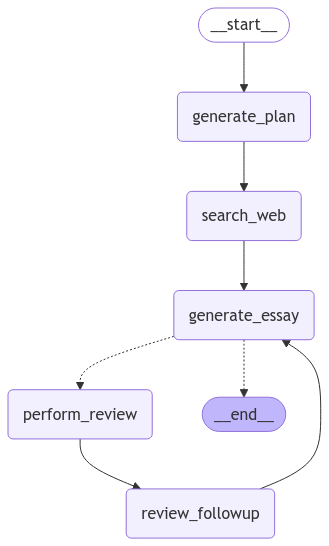

In [12]:
builder = StateGraph(AgentState, input=InputState, output=OutputState)

builder.add_node("generate_plan", generate_plan)
builder.add_node("search_web", search_web)
builder.add_node("generate_essay", generate_essay)
builder.add_node("perform_review", perform_review)
builder.add_node("review_followup", review_followup)


builder.add_edge(START, "generate_plan")
builder.add_conditional_edges("generate_essay",
                              should_continue,
                              {END: END, "perform_review": "perform_review"})
builder.add_edge("generate_plan", "search_web")
builder.add_edge("search_web", "generate_essay")
builder.add_edge("perform_review", "review_followup")
builder.add_edge("review_followup", "generate_essay")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

# Show
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

As we can see, the first version of the Researcher is very basic. It always performs 3 round of critique and does not allow parallel research. Moreover, it relies only on web documents.

We will address those issues in the next versions.

## Test

Ora passiamo al test del grafo

In [13]:
from IPython.display import Markdown

state = InputState(topic="pickup della chitarra elettrica",
                   user_notes="Il report deve essere semplice da leggere anche per chi non capisce nulla di chitarre",
                   max_revisions=2,
                   desired_language="italian")

configurable = {"configurable": {"thread_id": "1"}}

graph.invoke(input=state, config=configurable)

result = graph.get_state(configurable)

# print(result)

# result is a tuple
Markdown(result.values["draft"])



# L'universo dei pickup della chitarra elettrica: Uno sguardo approfondito

## Che cos'è un pickup?

I pickup delle chitarre elettriche sono componenti essenziali che trasformano le vibrazioni delle corde in segnali elettrici. Questi segnali vengono poi amplificati per produrre il suono che ascoltiamo da un altoparlante. Alla base del funzionamento dei pickup c'è il principio dell'induzione elettromagnetica: una combinazione di un magnete e una bobina di filo che interagiscono con le corde della chitarra per generare un segnale [StayTunedGuitar](https://staytunedguitar.com/guitar-pickup-anatomy).

## Componenti di un pickup

Un pickup per chitarra elettrica è composto da tre componenti principali: un magnete, una bobina di filo e una struttura che li metta in relazione tra loro. Quando le corde della chitarra vibrano, disturbano il campo magnetico prodotto dal magnete. Questo disturbo viene catturato dalla bobina, che trasforma l'energia magnetica in un segnale elettrico [Tonepedia](https://www.tonepedia.com/electric-guitar-pickups/).

## Storia e varietà dei pickup

La storia dei pickup per chitarra elettrica è ricca di innovazioni. I primi pickup monotelo sono stati introdotti da Fender sulla Telecaster e sono noti per i loro toni brillanti e nitidi. Gibson ha risposto con i pickup P-90 e successivamente con gli humbucker, progettati per risolvere i problemi di rumore delle prime versioni [StayTunedGuitar](https://staytunedguitar.com/history-of-guitar-pickups).

## Differenze tra single-coil e humbucker

I pickup single-coil e humbucker sono i due tipi principali di pickup, ciascuno con un design unico che influenza il tono e le prestazioni. I single-coil producono un suono brillante e chiaro, mentre gli humbucker danno un suono più caldo e potente. Gli humbucker, infatti, sono essenzialmente due pickup single-coil uniti insieme, riducendo al minimo le interferenze esterne [GuitarSpace](https://guitarspace.org/electric-guitars/humbucker-vs-single-coil/).

## L'influenza del posizionamento e della resistenza

Il posizionamento del pickup sulla chitarra influisce significativamente sul tono prodotto. Pickup vicini al ponte tendono a offrire un suono più acuto e ricco di alti, mentre quelli vicino al manico producono un tono più profondo e ricco di bassi. Inoltre, la resistenza del pickup, che varia da modelli vintage a moderni, può plasmarne la qualità tonale [GodDamnelectrix](https://goddamnelectrix.com/humbucker-pickup-resistance/).

## L'evoluzione dei pickup

Nel corso degli anni, i pickup per chitarra elettrica hanno visto molte innovazioni tecnologiche. Dai design classici degli anni '50 fino ai pickup attivi degli anni '80 introdotti da EMG, che utilizzano elettronica interna per migliorare il tono e l'output, il ruolo dei pickup nella musica moderna non può essere sottovalutato [GodDamnelectrix](https://goddamnelectrix.com/single-coil-pickup-history/).

## Impatto sul tono della chitarra

I pickup hanno un impatto importante sul tono della chitarra. Infatti, molti chitarristi con il tempo finiscono per sperimentare con diversi tipi di pickup per trovare il suono che più si addice al loro stile musicale. La scelta dei potenziometri e dei condensatori nella circuiteria della chitarra può ulteriormente influenzare il tono complessivo [AllForTurntables](https://allforturntables.com/2023/10/02/how-do-guitar-pickups-affect-sound/).

## Scegliere il pickup giusto

La scelta del pickup giusto dipende dallo stile musicale e dalle preferenze tonali di ogni musicista. Alcuni chitarristi preferiscono il suono brillante dei single-coil, mentre altri scelgono la potenza degli humbucker. Possedono un'importante distinzione tonale che può fare una grande differenza nell'esperienza di suonare una chitarra [RockIslandSound](https://www.rockislandsound.com/post/humbuckers-vs-single-coils-which-guitar-pickup-is-right-for-you).

## Innovazioni future

Nel futuro, i pickup continueranno a evolversi, sfruttando magneti più potenti e geometrie diverse rispetto a quelle tradizionali. Sebbene l’elettronica negli strumenti continui a espandere il numero di opzioni tonali possibili, la ricerca di un suono naturale e dinamico continua a essere al primo posto per molti musicisti [Reverb](https://reverb.com/news/the-future-of-the-electric-guitar).

## Conclusione

I pickup della chitarra elettrica rappresentano il cuore pulsante di quest'iconico strumento. Da semplici componenti a pezzi di alta tecnologia, hanno rivoluzionato il modo in cui la musica moderna viene creata e interpretata. Con un ruolo chiave nel definire il tono, i pickup continueranno a ispirare generazioni di musicisti in tutto il mondo.

## Fonti

1. [Tonepedia](https://www.tonepedia.com/electric-guitar-pickups/)
2. [StayTunedGuitar](https://staytunedguitar.com/guitar-pickup-anatomy)
3. [GodDamnelectrix](https://goddamnelectrix.com/humbucker-pickup-resistance/)
4. [GodDamnelectrix](https://goddamnelectrix.com/single-coil-pickup-history/)
5. [AllForTurntables](https://allforturntables.com/2023/10/02/how-do-guitar-pickups-affect-sound/)
6. [RockIslandSound](https://www.rockislandsound.com/post/humbuckers-vs-single-coils-which-guitar-pickup-is-right-for-you)
7. [Reverb](https://reverb.com/news/the-future-of-the-electric-guitar)
8. [GuitarSpace](https://guitarspace.org/electric-guitars/humbucker-vs-single-coil/)
9. [StayTunedGuitar](https://staytunedguitar.com/history-of-guitar-pickups)